In [6]:
root = '/home/fesiib/doc2slide/dev/intro_to_dl_project'

import os
from pathlib import Path

import numpy as np

import torch

from torch.utils.data import DataLoader

from preprocess_root import init_dataset
from model import SlideDeckEncoder, Generator, Discriminator
#from model_no_encoder import Generator, Discriminator

from utils_transformer import SortByRefSlide, draw_bbs, get_Tensor, get_device, get_args

device = get_device()
args = get_args()
Tensor = get_Tensor()

result_dir = Path(root) / 'results'

In [3]:
def load_chekpoint(path, models, optimizers):
    path = os.path.join(path, 'checkpoint_249.pt')
    print(path)
    try:
       checkpoint = torch.load(path)
    except:
        print("Couldn't load the last checkpoint!")
        return models, optimizers, -1

    models['encoder'].load_state_dict(checkpoint['model_encoder_state_dict'])
    models['discriminator'].load_state_dict(checkpoint['model_discriminator_state_dict'])
    models['generator'].load_state_dict(checkpoint['model_generator_state_dict'])
    
    optimizers['encoder'].load_state_dict(checkpoint['optimizer_encoder_state_dict'])
    optimizers['generator'].load_state_dict(checkpoint['optimizer_generator_state_dict'])
    optimizers['discriminator'].load_state_dict(checkpoint['optimizer_discriminator_state_dict'])
    epoch = checkpoint['epoch']

    return models, optimizers, epoch

In [4]:
(train_dataset, test_dataset) = init_dataset(root, args.normalized)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, drop_last=True)

/home/fesiib/doc2slide/dev/intro_to_dl_project/data/bbs
file:  slide_deck_dataset_bmvc13.csv
file:  slide_deck_dataset_nips18.csv
file:  slide_deck_dataset_cvpr20.csv
file:  slide_deck_dataset_acl20.csv
file:  slide_deck_dataset_emnlp18.csv
file:  slide_deck_dataset_naacl19.csv
file:  slide_deck_dataset_eccv20.csv
file:  slide_deck_dataset_acl17.csv
file:  slide_deck_dataset_iclr20.csv
file:  slide_deck_dataset_cvpr10.csv
file:  slide_deck_dataset_eccv12.csv
file:  slide_deck_dataset_bmvc12.csv
file:  slide_deck_dataset_icml19.csv
file:  slide_deck_dataset_acl18.csv
file:  slide_deck_dataset_eccv14.csv
file:  slide_deck_dataset_icml20.csv
file:  slide_deck_dataset_fg15.csv
file:  slide_deck_dataset_emnlp17.csv
file:  slide_deck_dataset_nips19.csv
26820
7780


In [7]:


encoder = SlideDeckEncoder(
    args.num_label, args.slide_deck_embedding_size, args.slide_deck_N, args.padding_idx, 
    args.D_d_model, args.D_nhead, args.D_num_layers
).to(device)

generator = Generator(
    args.latent_size, args.num_label, args.slide_deck_embedding_size, args.padding_idx,
    d_model=args.G_d_model,
    nhead=args.G_nhead,
    num_layers=args.G_num_layers,
).to(device)

discriminator = Discriminator(
    args.num_label, args.slide_deck_embedding_size, args.max_seq_length, args.padding_idx,
    d_model=args.D_d_model,
    nhead=args.D_nhead,
    num_layers=args.D_num_layers,
).to(device)

models = {
    "discriminator": discriminator,
    "encoder" : encoder,
    "generator" : generator,
}

optimizers = {
    "discriminator": torch.optim.Adam(models["discriminator"].parameters(), lr=args.lr),
    "generator": torch.optim.Adam(models["generator"].parameters(), lr=args.lr),
    "encoder" : torch.optim.Adam(models["encoder"].parameters(), lr=args.lr)
}


parent_dir = result_dir / 'trial_transf_5'


(models, optimizers, loaded_epoch) = load_chekpoint(parent_dir, models, optimizers)

print(f"Loaded Epoch: {loaded_epoch} from {parent_dir}")

/home/fesiib/doc2slide/dev/intro_to_dl_project/results/trial_transf_5/checkpoint_249.pt
Loaded Epoch: 249 from /home/fesiib/doc2slide/dev/intro_to_dl_project/results/trial_transf_5


In [8]:
for model in models:
    models[model].eval()

Slide Deck


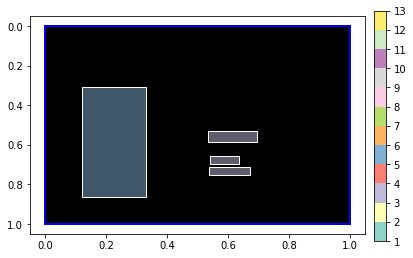

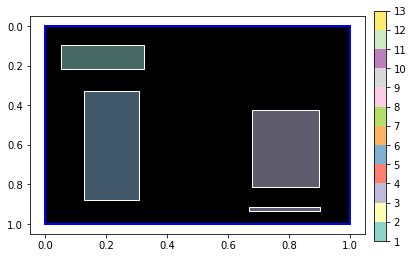

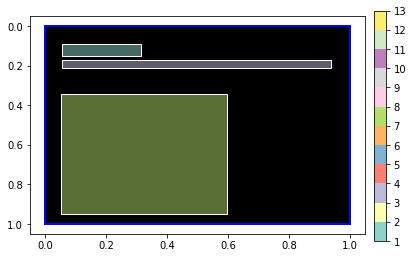

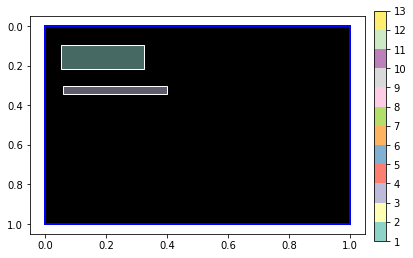

Ground Truth Slide


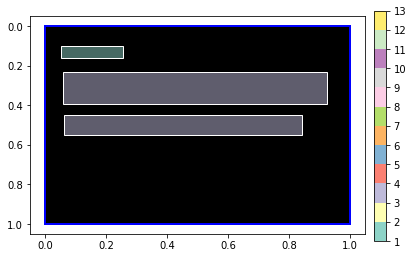

In [16]:
batch = list(test_loader)[0]
batch = SortByRefSlide(batch)
shape = batch["shape"].to(device)
slide_deck = batch["slide_deck"].to(device)
lengths_slide_deck = batch["lengths_slide_deck"].to(device)
ref_length = batch["length_ref_types"].to(device)
ref_types = batch["ref_types"].to(device).long()
ref_slide = batch["ref_slide"].to(device)

# deck encdoing
slide_deck = torch.transpose(slide_deck, 0, 1)
lengths_slide_deck = torch.transpose(lengths_slide_deck, 0, 1)
bboxes = slide_deck[:, :, :, :-1]
labels = slide_deck[:, :, :, -1].long()
padding_masks = ~(lengths_slide_deck[:, :, None] > torch.arange(labels.size(2)).to(device)[None, :])
models['encoder'].zero_grad()
deck_enc = models['encoder'](bboxes, labels, padding_masks)

label = ref_types

padding_mask = ~(ref_length[:, None] > torch.arange(label.size(1)).to(device)[None, :])
bbox_real = ref_slide[:, :, :-1]

n = 8
real_layouts_bbs = ref_slide[:,:,:-1]
print("Slide Deck")
for i in range(4):
    draw_bbs(shape[n], bboxes[i, n, :, :], labels[i, n, :], False)

print("Ground Truth Slide")
draw_bbs(shape[n],real_layouts_bbs[n], ref_types[n], False)


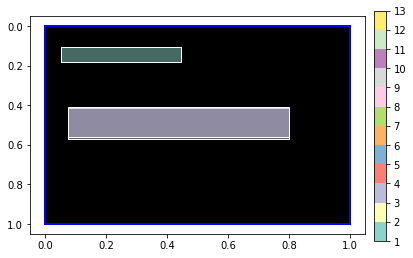

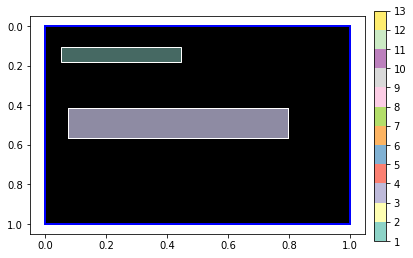

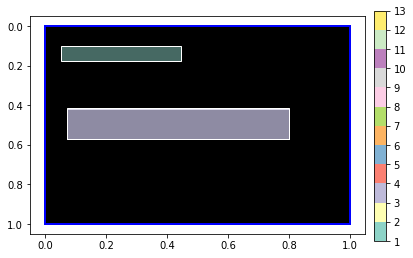

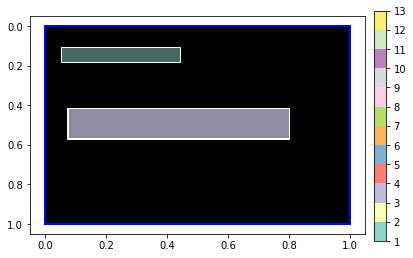

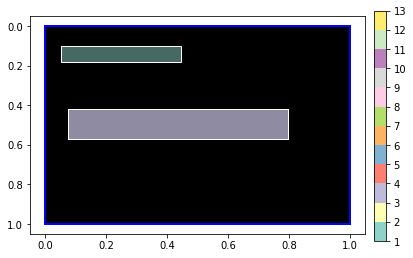

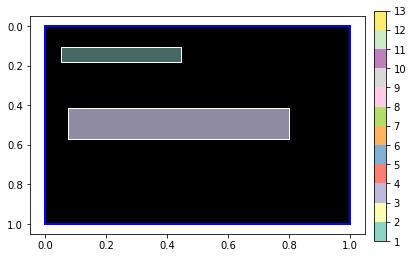

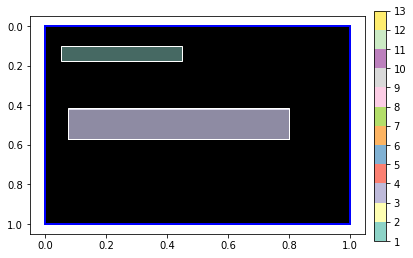

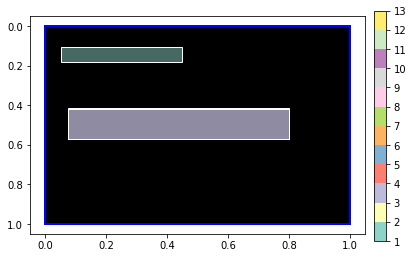

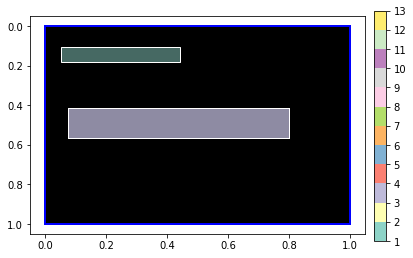

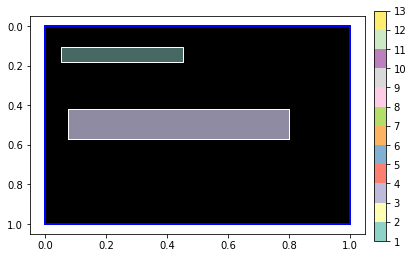

In [18]:
for i in range(10):
    z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (label.size(0), label.size(1), args.latent_size))))

    optimizers["encoder"].zero_grad()
    optimizers["discriminator"].zero_grad()

    # Sample noise as generator input
    fake_layouts_bbs = models['generator'](z[n:n+1], label[n:n+1], deck_enc[n:n+1], padding_mask[n:n+1]).detach()
    draw_bbs(shape[n], fake_layouts_bbs[0], ref_types[n], False)